In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Import packages
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep
import os

#Import Custom Classes

from Source.nn_model_dqn import QNetwork
from Source.dqn_rcv_agent import Agent, ReplayBuffer, EpsilonGreedyStrategy
from Source.env_manager import EnvManager
from Source.misc_fun.utils import plot, get_moving_average, Generate_BeamDir, All_Exhaustive_RateMeas
from Source.PER import PrioritizedReplayBuffer

In [3]:
#Hyper-parameters
BUFFER_SIZE = 8#int(1e5)      #replay buffer size
BATCH_SIZE = 8#128             #minibatch size
GAMMA = 0.999                #discount factor
ALPHA = 1.0                  #non-stationarity parameter
TAU = 1e-3                  #for soft update of target parameters
LR = 5e-4                   #learning rate
TEST_EVERY = 1600            #how often to test the network
UPDATE_EVERY =20
eps_start = 1.0
eps_end = 0.5
eps_decay = 0.997 #125e-6
PER_ALPHA = 0.6
PER_BETA = 0.4
PRIORITIZED_REPLAY = False

episodes = 3100 #3100 train, 500 test
seed = 0                    #random seed number
#%%
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inp_fptr = open("ricianch_variation.txt")
ch_randvals = inp_fptr.read().splitlines()
ch_randvals = [np.complex(a.replace('i','j')) for a in ch_randvals]

In [4]:
print(ch_randvals[0])

#print(np.complex(ch_randvals[0].replace('i','j')))

(1.1128+0.0082264j)


Beamset: [(0.39269908, 8) (0.78539816, 8) (1.17809725, 8) (1.57079633, 8)
 (1.96349541, 8) (2.35619449, 8) (2.74889357, 8) (3.14159265, 8)]
Bemset in deg: [(22.500000000000004, 8), (45.0, 8), (67.5, 8), (90.0, 8), (112.5, 8), (135.0, 8), (157.5, 8), (180.0, 8)]
Ntx: 8, active Ntx: 4, Beam: [ 0.35355339+0.j         -0.21414724-0.28132003j -0.09413548+0.34079101j
  0.32818294-0.13151411j -0.30342524-0.18147485j  0.03938632+0.3513527j
  0.25571266-0.24415371j -0.34915657-0.05558496j]


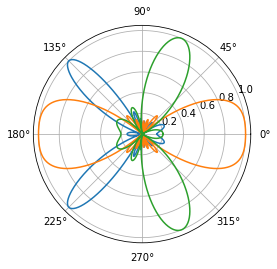

In [5]:
#Testing (beam_dir, beam_width) Beamset
from Source.antenna.ula import var_steervec
from Source.misc_fun.utils import Generate_Beams, var_plotbeam

width_vec = np.array([np.pi/8])
beamset = Generate_Beams(8,width_vec)

print("Beamset: {}".format(beamset))
print("Bemset in deg: {}".format([(x[0]*180/np.pi,x[1]) for x in beamset]))

tx_beam = var_steervec(8,beamset[5], 0)
print("Ntx: {}, active Ntx: {}, Beam: {}".format(8, 4, tx_beam))

theta, gr = var_plotbeam(beamset[5], 8)
theta2, gr2 = var_plotbeam(beamset[7], 8)
theta3, gr3 = var_plotbeam(beamset[2], 4)
ax = plt.subplot(111, projection='polar')
##print(theta.shape, gr.shape)
ax.plot(theta,gr, theta2, gr2, theta3,gr3)
plt.show()
    

In [6]:
#Choose the environment
em = EnvManager(device, 'combrf-v11', seed)
available_actions = em.num_actions_available()
random.seed(seed)
state_size = em.state_size()
print(em.env.ch_model)
print(em.env.sc_xyz)
#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 3500)

if PRIORITIZED_REPLAY:
    beta_strategy = EpsilonGreedyStrategy(PER_BETA, 1.0, eps_decay, 3500)

#Initialize the agent
agent = Agent(strategy, state_size, available_actions, seed, device)

#Instantiate MemoryBuffer
if not PRIORITIZED_REPLAY:
    memory = ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)
else:
    memory = PrioritizedReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, PER_ALPHA,seed, device)

policy_net = QNetwork(state_size, available_actions, seed).to(device)
target_net = QNetwork(state_size, available_actions, seed).to(device)
print(policy_net)

#Initialize target_net weights to policy_net weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #Set the target_net in eval mode

#Select the optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)

uma-nlos
[[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
QNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=5, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=64, bias=True)
  )
  (softmax): Softmax(dim=1)
  (output): Linear(in_features=64, out_features=8, bias=True)
)


In [7]:
print("tx_locs: {}".format(em.env.tx_locs))

tx_locs: [array([[-60.18150232, -79.863551  ,  21.5       ]])]


In [8]:
print("Beamset: {}".format(em.env.BeamSet))

Beamset: [(0.39269908, 8) (0.78539816, 8) (1.17809725, 8) (1.57079633, 8)
 (1.96349541, 8) (2.35619449, 8) (2.74889357, 8) (3.14159265, 8)]


## Test with random untrained actions

In [9]:
obs = em.env.reset(np.exp(1j * 2 * np.pi * 0.6),0)
#print(len(em.env.beamwidth_vec))
#print(em.env.action_space.n)
print(obs)
ep_rwd=[]
while True:
    action = random.randrange(em.env.action_space.n)
    
    obs, rwd, done,_ = em.env.step(action)
    print(action)
    ep_rwd.append(rwd)
    if done:
        break
        
print("Episode score: {}".format(np.sum(ep_rwd)))

[[ 0.          0.         -0.0601815  -0.07986355  0.95555556]]
6
6
0
4
7
6
4
Episode score: -1.0


In [10]:
moving_rpts = [[np.array([rp_loc])] for rp_loc in em.env.sc_xyz]

#print("Initial: \n", moving_rpts)

for i in range(2):
    for ndx in range(len(moving_rpts)):
        if (ndx == 0) or (ndx == 1):
            last_loc = moving_rpts[ndx][-1]
            new_loc = np.array([[last_loc[0][0]+em.env.rx_stepsize, last_loc[0][1], last_loc[0][2]]]) 
            moving_rpts[ndx].append(new_loc)
        elif (ndx == 2) or (ndx == 3):
            last_loc = moving_rpts[ndx][-1]
            new_loc = np.array([[last_loc[0][0], last_loc[0][1]-em.env.rx_stepsize, last_loc[0][2]]]) 
            moving_rpts[ndx].append(new_loc)

print("After adding moving patterns: ", moving_rpts)



After adding moving patterns:  [[array([[-100. ,   50. ,   21.5]]), array([[ 0. , 50. , 21.5]]), array([[100. ,  50. ,  21.5]])], [array([[-100. ,  -50. ,   21.5]]), array([[  0. , -50. ,  21.5]]), array([[100. , -50. ,  21.5]])], [array([[-50. , 100. ,  21.5]]), array([[-50. ,   0. ,  21.5]]), array([[ -50. , -100. ,   21.5]])], [array([[ 50. , 100. ,  21.5]]), array([[50. ,  0. , 21.5]]), array([[  50. , -100. ,   21.5]])]]


In [11]:
eps_scpts = []

for i in range(episodes):
    #print(random.choice(moving_rpts[0]))
    sc_pts = np.array([random.choice(moving_rpts[ndx])[0] for ndx in range(len(moving_rpts))])
    eps_scpts.append(sc_pts)

#print(eps_scpts)

In [12]:
print(eps_scpts[7])

[[ 100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.  -100.    21.5]
 [  50.     0.    21.5]]


In [13]:
print(em.env.obs_space.nvec[3])

1


## Train the DQN agent

Episode 3000,	Score: 2.00, eps: 0.8901219512195122, moving avg_rwd: 0.5400000214576721, , ep_len: 8, ep_loss: 3.31168031692504947
test_eps: 3000, eps_rwd: 2.0
TX loc: [[-60.18150232 -79.863551    21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX dirs:  [(22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8)]
RX dirs:  [(90.0, 8), (112.5, 8), (22.500000000000004, 8), (90.0, 8), (180.0, 8), (45.0, 8), (67.5, 8)]
data rates: [8.52381843316407, 11.983617123850069, 11.697270939082042, 8.52381843316407, 13.746617724373305, 10.155309911138831, 10.55354929225444]
min exh_rate: 8.52381843316407, min_action_ndx: 3, beamset val: (90.0,8)
max exh_rate: 14.617330873733177, max_action_ndx: 6, beamset val: (157.5,8)

Episode 3001,	Score: -1.00, eps: 0.89, moving avg_rwd: 0.5099999904632568, , ep_len: 8, ep_loss: 

Episode 3010,	Score: 0.00, eps: 0.8889024390243903, moving avg_rwd: 0.6100000143051147, , ep_len: 8, ep_loss: 5.032464981079102
test_eps: 3010, eps_rwd: 0.0
TX loc: [[-60.18150232 -79.863551    21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX dirs:  [(22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8)]
RX dirs:  [(90.0, 8), (45.0, 8), (135.0, 8), (112.5, 8), (22.500000000000004, 8), (22.500000000000004, 8), (180.0, 8)]
data rates: [8.52381843316407, 10.155309911138831, 14.578160584987755, 11.983617123850069, 11.697270939082042, 11.697270939082042, 13.746617724373305]
min exh_rate: 8.52381843316407, min_action_ndx: 3, beamset val: (90.0,8)
max exh_rate: 14.617330873733177, max_action_ndx: 6, beamset val: (157.5,8)

Episode 3011,	Score: 4.00, eps: 0.8887804878048781, moving avg_rwd: 0.64999997615

Episode 3021,	Score: 0.00, eps: 0.8875609756097561, moving avg_rwd: 0.7599999904632568, , ep_len: 8, ep_loss: 3.953162670135498
test_eps: 3021, eps_rwd: 0.0
TX loc: [[-60.18150232 -79.863551    21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX dirs:  [(22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8)]
RX dirs:  [(90.0, 8), (45.0, 8), (157.5, 8), (67.5, 8), (67.5, 8), (45.0, 8), (157.5, 8)]
data rates: [8.52381843316407, 10.155309911138831, 14.617330873733177, 10.55354929225444, 10.55354929225444, 10.155309911138831, 14.617330873733177]
min exh_rate: 8.52381843316407, min_action_ndx: 3, beamset val: (90.0,8)
max exh_rate: 14.617330873733177, max_action_ndx: 6, beamset val: (157.5,8)

Episode 3022,	Score: 0.00, eps: 0.8874390243902439, moving avg_rwd: 0.7699999809265137, , ep_len: 8, ep_loss: 3.

Episode 3031,	Score: 0.00, eps: 0.8863414634146342, moving avg_rwd: 0.7900000214576721, , ep_len: 8, ep_loss: 4.648137092590332
test_eps: 3031, eps_rwd: 0.0
TX loc: [[-60.18150232 -79.863551    21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX dirs:  [(22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8)]
RX dirs:  [(90.0, 8), (180.0, 8), (157.5, 8), (135.0, 8), (157.5, 8), (180.0, 8), (67.5, 8)]
data rates: [8.52381843316407, 13.746617724373305, 14.617330873733177, 14.578160584987755, 14.617330873733177, 13.746617724373305, 10.55354929225444]
min exh_rate: 8.52381843316407, min_action_ndx: 3, beamset val: (90.0,8)
max exh_rate: 14.617330873733177, max_action_ndx: 6, beamset val: (157.5,8)

Episode 3032,	Score: 1.00, eps: 0.886219512195122, moving avg_rwd: 0.7699999809265137, , ep_len: 8, ep_loss:

Episode 3041,	Score: 3.00, eps: 0.8851219512195122, moving avg_rwd: 0.800000011920929, , ep_len: 8, ep_loss: 3.915187358856201
test_eps: 3041, eps_rwd: 3.0
TX loc: [[-60.18150232 -79.863551    21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX dirs:  [(22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8)]
RX dirs:  [(90.0, 8), (112.5, 8), (180.0, 8), (157.5, 8), (22.500000000000004, 8), (180.0, 8), (22.500000000000004, 8)]
data rates: [8.52381843316407, 11.983617123850069, 13.746617724373305, 14.617330873733177, 11.697270939082042, 13.746617724373305, 11.697270939082042]
min exh_rate: 8.52381843316407, min_action_ndx: 3, beamset val: (90.0,8)
max exh_rate: 14.617330873733177, max_action_ndx: 6, beamset val: (157.5,8)

Episode 3042,	Score: 4.00, eps: 0.885, moving avg_rwd: 0.8199999928474426, , ep_l

Episode 3051,	Score: 1.00, eps: 0.8839024390243903, moving avg_rwd: 0.8700000047683716, , ep_len: 8, ep_loss: 4.547840595245361
test_eps: 3051, eps_rwd: 1.0
TX loc: [[-60.18150232 -79.863551    21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX dirs:  [(22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8)]
RX dirs:  [(90.0, 8), (112.5, 8), (157.5, 8), (45.0, 8), (90.0, 8), (112.5, 8), (180.0, 8)]
data rates: [8.52381843316407, 11.983617123850069, 14.617330873733177, 10.155309911138831, 8.52381843316407, 11.983617123850069, 13.746617724373305]
min exh_rate: 8.52381843316407, min_action_ndx: 3, beamset val: (90.0,8)
max exh_rate: 14.617330873733177, max_action_ndx: 6, beamset val: (157.5,8)

Episode 3052,	Score: 0.00, eps: 0.8837804878048781, moving avg_rwd: 0.8600000143051147, , ep_len: 8, ep_loss: 

Episode 3061,	Score: 0.00, eps: 0.8826829268292683, moving avg_rwd: 0.8700000047683716, , ep_len: 8, ep_loss: 6.408166885375977
test_eps: 3061, eps_rwd: 0.0
TX loc: [[-60.18150232 -79.863551    21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX dirs:  [(22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8)]
RX dirs:  [(90.0, 8), (45.0, 8), (112.5, 8), (180.0, 8), (180.0, 8), (22.500000000000004, 8), (180.0, 8)]
data rates: [8.52381843316407, 10.155309911138831, 11.983617123850069, 13.746617724373305, 13.746617724373305, 11.697270939082042, 13.746617724373305]
min exh_rate: 8.52381843316407, min_action_ndx: 3, beamset val: (90.0,8)
max exh_rate: 14.617330873733177, max_action_ndx: 6, beamset val: (157.5,8)

Episode 3062,	Score: 3.00, eps: 0.8825609756097561, moving avg_rwd: 0.8899999856948853, , ep_l

Episode 3071,	Score: 2.00, eps: 0.8814634146341463, moving avg_rwd: 0.9599999785423279, , ep_len: 8, ep_loss: 5.579113006591797
test_eps: 3071, eps_rwd: 2.0
TX loc: [[-60.18150232 -79.863551    21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX dirs:  [(22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8)]
RX dirs:  [(90.0, 8), (90.0, 8), (180.0, 8), (67.5, 8), (135.0, 8), (157.5, 8), (90.0, 8)]
data rates: [8.52381843316407, 8.52381843316407, 13.746617724373305, 10.55354929225444, 14.578160584987755, 14.617330873733177, 8.52381843316407]
min exh_rate: 8.52381843316407, min_action_ndx: 3, beamset val: (90.0,8)
max exh_rate: 14.617330873733177, max_action_ndx: 6, beamset val: (157.5,8)

Episode 3072,	Score: -1.00, eps: 0.8813414634146342, moving avg_rwd: 0.9100000262260437, , ep_len: 8, ep_loss: 2.7

Episode 3081,	Score: 0.00, eps: 0.8802439024390244, moving avg_rwd: 0.9200000166893005, , ep_len: 8, ep_loss: 3.7207703590393066
test_eps: 3081, eps_rwd: 0.0
TX loc: [[-60.18150232 -79.863551    21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX dirs:  [(22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8)]
RX dirs:  [(90.0, 8), (180.0, 8), (180.0, 8), (90.0, 8), (90.0, 8), (157.5, 8), (135.0, 8)]
data rates: [8.52381843316407, 13.746617724373305, 13.746617724373305, 8.52381843316407, 8.52381843316407, 14.617330873733177, 14.578160584987755]
min exh_rate: 8.52381843316407, min_action_ndx: 3, beamset val: (90.0,8)
max exh_rate: 14.617330873733177, max_action_ndx: 6, beamset val: (157.5,8)

Episode 3082,	Score: 1.00, eps: 0.8801219512195122, moving avg_rwd: 0.9200000166893005, , ep_len: 8, ep_loss: 1

Episode 3091,	Score: 2.00, eps: 0.8790243902439024, moving avg_rwd: 0.9900000095367432, , ep_len: 8, ep_loss: 5.059904098510742
test_eps: 3091, eps_rwd: 2.0
TX loc: [[-60.18150232 -79.863551    21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX dirs:  [(22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8)]
RX dirs:  [(90.0, 8), (90.0, 8), (45.0, 8), (67.5, 8), (157.5, 8), (112.5, 8), (67.5, 8)]
data rates: [8.52381843316407, 8.52381843316407, 10.155309911138831, 10.55354929225444, 14.617330873733177, 11.983617123850069, 10.55354929225444]
min exh_rate: 8.52381843316407, min_action_ndx: 3, beamset val: (90.0,8)
max exh_rate: 14.617330873733177, max_action_ndx: 6, beamset val: (157.5,8)

Episode 3092,	Score: 0.00, eps: 0.8789024390243902, moving avg_rwd: 0.9599999785423279, , ep_len: 8, ep_loss: 2.26

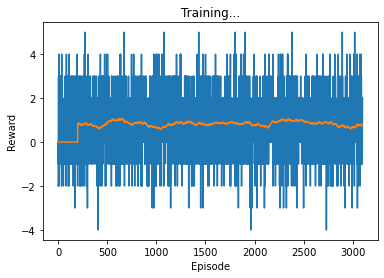

No. of false positives: 0


In [14]:
ep_rewards = []
test_rewards = []
test_data_rates = []
test_eps_iters=[]
test_minexh_rates = []
test_maxexh_rates = []
false_positives =0
policy_net.train()
test_txbdir = 0

strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 4100)
outer = tqdm.notebook.tqdm(total=episodes, desc='training loop: ', position=0)
train_steps = 0
for episode in range(episodes):
 
    ep_loss = 0.0
    ep_rwd = 0.0
    timestep = 0
    tx_dirs = []
    rx_dirs = []
    data_rates =[]
    #agent.current_step +=1
    train_steps +=1
    
    
    #changing from LoS to NLoS and viceversa
    
    if((episode+1) == (episodes-1000)):
        strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 4100)
        train_steps = 1
    if ((episode+1) >= (episodes-1000)):    
        #strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 4100)
        eps = strategy.get_exploration_rate(train_steps)
        #print(eps, train_steps)
        agent.dqnaction_list = []
        agent.action_flag =-1
        em.env.sc_xyz = np.array([[-100,50,21.5], [-100,-50,21.5], [-50,100,21.5],[50,100,21.5]])#np.array([[-100,50,11.5], [-100,-50,11.5], [-50,100,11.5],[50,100,11.5]])#np.array([[50,0,0], [-50,-100,0], [100,50,0],[50,-100,0]])#np.array([[0,100,0], [10,50,0], [40,60,0], [70,80,0], [100,50,0], [80,85,0], [20,30,0], [10,40,0], [80,20,0]])#np.array([[0,100,0]])#np.array([[0,100,0],[250,0,0],[-200,-150,0]]) #reflection points for now
        em.env.ch_model ='uma-nlos'#'uma-nlos' #free-space path loss model
        em.env.init_ch_model = 'uma-nlos'
        obs = em.reset(ch_randvals[episode], eps)
        
        if(eps <= 0.5):
            agent.action_flag = 1
        #    agent.dqnaction_list.append(em.env.rbdir_ndx)
        else:
            agent.action_flag = 0
            
        em.env.action_list = []
        em.env.action_list.append(em.env.rbdir_ndx)
        agent.randaction_list = []
        agent.actionflag_list = []
        agent.randaction_list.append(em.env.rbdir_ndx)
        agent.actionflag_list.append(agent.action_flag)
        em.env.reward_list = []
        em.env.reward_list.append(float(np.around(1.0, decimals=2)))
        #em.env.temprwd_list = []
        #em.env.temprwd_list.append(float(np.around(1.0, decimals=2)))    
    
    elif ((episode+1) >= (episodes-100)):
        eps = strategy.get_exploration_rate(train_steps)
        agent.dqnaction_list = []
        agent.action_flag =-1
        tx_num = em.env.get_txloc_ndx(np.array([[-100*np.cos(53*np.pi/180),-100*np.sin(53*np.pi/180),21.5]]))
        rbdir_ndx = em.env.dqnbestbeam_ndxlist[tx_num * em.env.obs_space.nvec[3] + test_txbdir]
        rbdir_ndx = rbdir_ndx_tensor.item()
        #rbdir_ndx = 0
        
        obs = em.test_reset(np.array([[-100*np.cos(53*np.pi/180),-100*np.sin(53*np.pi/180),21.5]]), em.env.sc_xyz, ch_randvals[episode], rbdir_ndx,test_txbdir)
        test_txbdir = (test_txbdir + 1) % em.env.obs_space.nvec[3]
        em.env.reward_list = []
        em.env.reward_list.append(float(np.around(1.0, decimals=2)))
        #em.env.temprwd_list = []
        #em.env.temprwd_list.append(float(np.around(1.0, decimals=2)))
        
    else:
        eps = strategy.get_exploration_rate(train_steps)
        agent.dqnaction_list = []
        #tx_num = self.get_txloc_ndx(np.array([[-100,-100,21.5]]))
        #rbdir_ndx = em.env.dqnbestbeam_ndxlist[tx_num * self.obs_space.nvec[3] + test_txbdir]        
        agent.action_flag =-1
        obs = em.reset(ch_randvals[episode], eps)
        if(eps <= 0.5):
            agent.action_flag = 1
        #    agent.dqnaction_list.append(em.env.rbdir_ndx)
        else:
            agent.action_flag = 0
            
        em.env.action_list = []
        em.env.action_list.append(em.env.rbdir_ndx)
        agent.randaction_list = []
        agent.actionflag_list = []
        agent.randaction_list.append(em.env.rbdir_ndx)
        agent.actionflag_list.append(agent.action_flag)
        em.env.reward_list = []
        em.env.reward_list.append(float(np.around(1.0, decimals=2)))
        #em.env.temprwd_list = []
        #em.env.temprwd_list.append(float(np.around(1.0, decimals=2)))
        
    
    if PRIORITIZED_REPLAY:
        beta = beta_strategy.get_exploration_rate(train_steps)
    
    while True:
        tx_dirs.append((em.env.tx_bdir[0]*(180/np.pi), em.env.tx_bdir[1]))
        rx_dirs.append((em.env.rx_bdir[0]*(180/np.pi), em.env.rx_bdir[1]))
        data_rates.append(em.env.rate)

        agent.action_flag = -1
        action = agent.act(obs, policy_net, eps, 8)
        agent.actionflag_list.append(agent.action_flag)
        #print(action)
        next_obs, reward, done, _ = em.step(action)
        em.env.action_list.append(action.item())
        em.env.reward_list.append(float(np.around(reward.item(), decimals=2)))
        #em.env.temprwd_list.append(float(np.around(temp_rwd.item(), decimals=2)))
        #em.env.epsilon_list.append(eps)
        
        #agent.step(obs, action, reward, next_obs, done)
        ep_rwd += reward.item()
        
        min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx,_,_ = em.env.get_minmax_exhrate(ch_randvals[episode])
        
        next_qactionvals = target_net(next_obs).detach().data.cpu().numpy()[0]
        next_qactions= np.argsort(next_qactionvals)[::-1]
        
        #for a in next_qactions:
        #    if a not in agent.dqnaction_list:
        #        next_qact = a
        #        break
        next_act = torch.tensor(np.array([next_qactions[0]]), dtype=torch.long).to(device)
        #print("obs: {}, action: {}, reward: {}, next_obs:{}, next_action: {}, done: {}".format(obs, action, reward, next_obs, next_act, done))
        #print("dqnactionlist: {}, Next qactionvals: {}, next_qactions: {}, selected_nextact:{}".format(agent.dqnaction_list,next_qactionvals, next_qactions, next_act))
        #print(action)
        memory.add(obs, action, reward, next_obs, next_act, done)
        
        #current_qval = policy_net(obs).gather(1,index=action.unsqueeze(-1))
        #print(current_qval, current_qval.size())
        
        #print(next_qact, action)
        #next_qval = target_net(next_obs).detach().gather(1,index=next_qact.unsqueeze(-1))
        #print(next_qval)
        
        
        obs = next_obs
        
        if memory.can_provide_sample():

            if PRIORITIZED_REPLAY:
                experiences = memory.sample(beta)
                observations, actions, rewards, next_observations, dones, weights, batch_indices = experiences
            else:
                experiences = memory.sample()
                observations, actions, rewards, next_observations, next_actions, dones = experiences
                weights, batch_indices = torch.tensor(np.ones_like(rewards.cpu().data.numpy())).to(device), None

            #print(observations.shape, observations.dtype)
            #print(actions.unsqueeze(-1).shape)
            current_q_values = policy_net(observations).gather(1,index=actions.unsqueeze(-1))#(1-ALPHA)*

            #next_q_values = target_net(next_observations).detach().max(1)[0]
            next_q_values = target_net(next_observations).detach().gather(1,index=next_actions.unsqueeze(-1))#min(1)[0]
            #next_q_actionvals = target_net(next_observations).detach().data.cpu().numpy()[0]
            #next_qactions = np.argsort(next_q_actionvals)[::-1]
            #for i in range(len(next_qactions)):
            #    if next_qactions[i] not in agent.dqnaction_list:

            target_q_values = ((next_q_values*GAMMA*(~dones.unsqueeze(-1))) + rewards.unsqueeze(-1))
            #print(current_q_values.size())
            #print(target_q_values.size())
            #print(dones.unsqueeze(-1).size())
            #print(next_actions.size(), actions.size(), next_q_values.size(), rewards.unsqueeze(-1).size())
            #loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float())
            td_errors = ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values)
            loss = F.mse_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.float()-current_q_values),  reduction='sum')
            #loss = F.l1_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction=None)
            #loss = F.cross_entropy(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction='mean')
            #loss = F.cross_entropy(current_q_values, target_q_values.unsqueeze(1).long(),  reduction='mean')
            #print(target_q_values.float()-current_q_values)
            #weighted_loss = torch.mean(weights*loss)
            #print("loss: ", loss)
            #loss = ALPHA*loss
            #ep_loss += weighted_loss.item()
            ep_loss = loss.item()

            optimizer.zero_grad()
            #weighted_loss.backward()
            loss.backward()
            optimizer.step()

            if PRIORITIZED_REPLAY:
                comp_errors = np.array([x[0] for x in td_errors.cpu().data.numpy()])
                new_priorities = np.abs(comp_errors) + 1e-6
                #print(new_priorities)
                memory.update_priorities(batch_indices.cpu().data.numpy(), new_priorities)

            #Update the policy network
            #if episode % UPDATE_EVERY == 0:
            #    target_net.load_state_dict(policy_net.state_dict())
            for local_param, target_param in zip(policy_net.parameters(), target_net.parameters()):
                target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)
        
        timestep +=1
        if done:
        
            ep_rewards.append(ep_rwd)
            moving_avg_rwd = get_moving_average(100, ep_rewards)
            print('\rEpisode {},\tScore: {:.2f}, eps: {}, moving avg_rwd: {}, , ep_len: {}, ep_loss: {}'.format(episode+1, ep_rwd, eps, moving_avg_rwd[-1], em.env.rbdir_count, ep_loss), end="\r")
            #plot(episode_rewards, 100)
            if((episode+1) < (episodes-100)):
                tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
                em.env.dqneplen_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(em.env.rbdir_count)
                em.env.dqnepaction_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(em.env.action_list)
                em.env.dqnepsilon_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(eps)
                em.env.dqnactionflag_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(agent.actionflag_list)
                em.env.dqnactionrwd_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(em.env.reward_list)
                #em.env.dqntemprwd_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(em.env.temprwd_list)
                
                if((em.env.rbdir_count-1) == em.env.goal_steps):
                    em.env.dqneplen_counter[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] += 1
        
            #if(((episode+1) >= 6000) or (3000 <= (episode+1)<=3500)):
            if((episode+1) >= (episodes-100)):
                
                test_data_rates.append(max(data_rates))
                test_eps_iters.append(timestep)
                test_minexh_rates.append(min_exh_rate)
                test_maxexh_rates.append(max_exh_rate)
                
                #if (timestep > 3):
                #    if(timestep >=8):
                #        false_positives +=1
                #if (min_exh_rate == max_exh_rate):
                print("\ntest_eps: {0}, eps_rwd: {1}".format(episode+1, ep_rwd))
                print("TX loc: {}".format(em.env.tx_loc))
                print("SC_xyz: {}".format(em.env.sc_xyz))
                print("TX dirs: ", tx_dirs)
                print("RX dirs: ", rx_dirs)
                print("data rates: {}".format(data_rates))
                print("min exh_rate: {}, min_action_ndx: {}, beamset val: ({},{})".format(min_exh_rate, min_action_ndx, em.env.BeamSet[min_action_ndx][0]*180/np.pi,em.env.BeamSet[min_action_ndx][1]))
                print("max exh_rate: {}, max_action_ndx: {}, beamset val: ({},{})\n".format(max_exh_rate, max_action_ndx, em.env.BeamSet[max_action_ndx][0]*180/np.pi, em.env.BeamSet[max_action_ndx][1]))
                
            timestep = 0
            break
            
        
    
    '''    
    if ((episode == 0) or (episode+1) == 3100) or (((episode+1) > 3100) and ((train_steps) % (TEST_EVERY) == 0)):
        #test some episodes to check the performance
        policy_net.eval()
        test_ep_rwds = []
        for test_eps in range(test_episodes):
            obs = em.test_reset(test_loc, em.env.action_space.sample(), em.env.sc_xyz, ch_randvals[episode+test_eps+1])
            test_score=0
            tx_dirs = []
            rx_dirs = []
            data_rates =[]
            step = 0
            done = False
            while not done:
                action = policy_net(obs).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
                #print("timestep: ",step, policy_net(obs),policy_net(obs).size(), action)
                tx_dirs.append(em.env.tx_bdir*(180/np.pi))
                rx_dirs.append(em.env.rx_bdir*(180/np.pi))
                data_rates.append(em.env.rate)
                next_obs, reward, done, _ = em.step(action)
                step+=1
                print("\ntstep: {0}, obs: {1}, action: {2}, next_obs: {3}, rwd: {4}, done: {5}".format(step, obs.cpu().data.numpy(), action.cpu().data.numpy(), next_obs.cpu().data.numpy(), reward.item(), done.item()))
                test_score+=reward.item()
                obs = next_obs
            
            print("test_eps: {0}, eps_rwd: {1}".format(test_eps+1, test_score))
            print("TX loc: {}".format(em.env.tx_loc))
            print("TX dirs: ", tx_dirs)
            print("RX dirs: ", rx_dirs)
            print("data rates: {}".format(data_rates))
            min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx,_,_ = em.env.get_minmax_exhrate(ch_randvals[episode+test_eps+1])
            print("min exh_rate: {}, min_action_ndx: {}".format(min_exh_rate, min_action_ndx))
            print("max exh_rate: {}, max_action_ndx: {}".format(max_exh_rate, max_action_ndx))
            
            test_ep_rwds.append(test_score)
            test_rewards.append(test_score)
            test_data_rates.append(data_rates[-1])
            test_minexh_rates.append(min_exh_rate)
            test_maxexh_rates.append(max_exh_rate)
            
        print("Average test_ep_score: {}\n".format(np.mean(test_ep_rwds)))
        policy_net.train()
        #agent.current_step=0
        train_steps = 0
        strategy =EpsilonGreedyStrategy(0.5, eps_end, 0.997)#0.1
    else:
        test_rewards.append(0)
        test_data_rates.append(0)
        test_minexh_rates.append(0)
        test_maxexh_rates.append(0)
    '''
    # update tqdm bar
    outer.update(1)
    
torch.save(policy_net.state_dict(), 'checkpoint.pth')

#timer.finish()
plot(ep_rewards, 200, test_rewards)
print("No. of false positives: {}".format(false_positives))

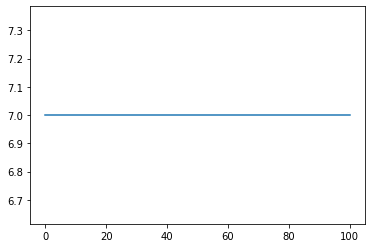

7.0 101


In [15]:
fig=plt.figure()
min_ndx=0
max_ndx=500
plt.plot(test_eps_iters[min_ndx:max_ndx])
plt.show()
print(np.mean(test_eps_iters), len(test_eps_iters))

In [16]:
print(em.env.ch_model)
print(em.env.sc_xyz)

test_net = QNetwork(state_size, available_actions, seed).to(device)
test_net.load_state_dict(torch.load('checkpoint.pth'))
test_net.eval()
tx_loc = np.array([[-100*np.cos(53*np.pi/180),-100*np.sin(53*np.pi/180),21.5]])
tbdir_ndx = 0
rbdir_ndx = 0
norm_tx_xloc = np.array([(tx_loc[0][0]) / 1000])  # np.max(self.rx_xcov)])#np.array([(self.tx_loc[0][0]+np.max(self.rx_xcov))/(np.max(self.rx_xcov))])#-np.min(self.rx_xcov))])
norm_tx_yloc = np.array([(tx_loc[0][1]) / 1000])  # max(np.max(self.rx_ycov),1)])#np.array([(self.tx_loc[0][1] + np.max(self.rx_ycov)) / (np.max(self.rx_ycov))])# - np.min(self.rx_ycov))])
norm_tx_zloc = np.array([(tx_loc[0][2]) / 22.5])
norm_tx_ndx = np.array([tbdir_ndx / em.env.obs_space.nvec[3]])
norm_rx_ndx = np.array([rbdir_ndx / em.env.action_space.n])
obs = np.array([np.concatenate((norm_rx_ndx, norm_tx_ndx, norm_tx_xloc, norm_tx_yloc,norm_tx_zloc), axis=0)])

obs_tensor = torch.tensor(obs, device=device, dtype=torch.float32)
#print(np.sort(test_net(obs_tensor).data.cpu().numpy()[0]))

uma-nlos
[[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]


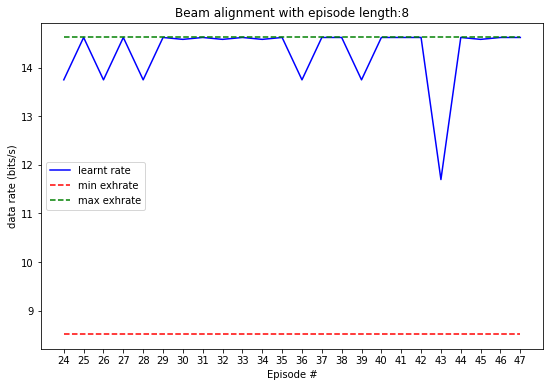

In [17]:
fig = plt.figure(figsize=[9, 6])
min_ndx=24
max_ndx=48
plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), test_data_rates[min_ndx:max_ndx], 'b', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_minexh_rates[min_ndx:max_ndx], 'r--', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'g--')
#plt.plot(np.arange(len(test_data_rates[3080:3140])), test_data_rates[3080:3140], 'b', np.arange(len(test_data_rates[3080:3140])), test_minexh_rates[3080:3140], 'r--', np.arange(len(test_data_rates[3080:3140])), test_maxexh_rates[3080:3140],'g--')
#plt.plot(np.arange(len(test_data_rates[4650:4740])), test_data_rates[4650:4740], 'b', np.arange(len(test_data_rates[4650:4740])), test_minexh_rates[4650:4740], 'r--', np.arange(len(test_data_rates[4650:4740])), test_maxexh_rates[4650:4740],'g--')
#plt.plot(np.arange(len(test_data_rates[6230:])), test_data_rates[6230:], 'b', np.arange(len(test_data_rates[6230:])), test_minexh_rates[6230:], 'r--', np.arange(len(test_data_rates[6230:])), test_maxexh_rates[6230:],'g--')

plt.xticks(np.arange(0, max_ndx-min_ndx), [str(x) for x in np.arange(min_ndx, max_ndx)])
plt.legend(['learnt rate','min exhrate', 'max exhrate'])
plt.xlabel('Episode #')
plt.ylabel('data rate (bits/s)')
plt.title('Beam alignment with episode length:{}'.format(em.env.goal_steps))
plt.show()

In [18]:
min_ndx=60
max_ndx=80
print(test_data_rates[min_ndx:max_ndx])
print(test_maxexh_rates[min_ndx:max_ndx])
print(em.env.sc_xyz)
print(em.env.ch_model)
print(em.env.init_ch_model)

[14.578160584987755, 13.746617724373305, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.578160584987755, 14.617330873733177, 14.578160584987755, 13.746617724373305, 14.617330873733177, 14.617330873733177, 14.578160584987755, 14.617330873733177]
[14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177, 14.617330873733177]
[[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
uma-nlos
uma-nlos


In [19]:
print(test_data_rates[69])
print([(x[0]*180/np.pi, x[1]) for x in em.env.BeamSet])
#print(em.env.BeamSet[9])

14.617330873733177
[(22.500000000000004, 8), (45.0, 8), (67.5, 8), (90.0, 8), (112.5, 8), (135.0, 8), (157.5, 8), (180.0, 8)]


In [20]:
print(em.env.dqnobs_counter)
print(len(em.env.dqnobs_counter))
print(np.mean(em.env.dqnobs_counter))

[3101]
1
3101.0


In [21]:
print(em.env.dqneplen_counter)
print(np.mean(em.env.dqneplen_counter))

[0]
0.0


In [22]:
tx_loc = np.array([[-100*np.cos(53*np.pi/180),-100*np.sin(53*np.pi/180),21.5]])
txdir_ndx = 0

tx_num = em.env.get_txloc_ndx(tx_loc)
obs_epiters = em.env.dqneplen_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx]

count = 0
for x,y,z,w in zip(em.env.dqnepaction_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx],em.env.dqnepsilon_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx],em.env.dqnactionflag_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx], em.env.dqnactionrwd_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx]):
    #print("episode actions: {}, eps: {}".format(x,y,z))
    temp_list =[(i,j,k) for i,j,k in zip(x,z,w)]
    count = count + 1
    if (count >2980):
        print("NLoS episode actions: {}, eps: {}".format(temp_list,y))
    elif (count >=2100 and count <2360):
        print("NLoS-random episode actions: {}, eps: {}".format(temp_list,y))
    
    elif(count > 1990 and count <= 2000):
    #    break
        print("LoS episode actions: {}, eps: {}".format(temp_list,y))
    #else:
    #    pass
    
        
#print(em.env.dqnepsilon_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx])
#fig = plt.figure(figsize=[9, 6])
#plt.plot(np.arange(len(obs_epiters)), obs_epiters, 'b')
#plt.xlabel('Episode #')
#plt.ylabel('Episode Iterations')
#plt.title('Training convergence for tx_loc:{}, txdir: {}, ep_len:{}'.format(tx_loc, (em.env.BeamSet[txdir_ndx][0]*180/np.pi,em.env.BeamSet[txdir_ndx][1]),em.env.goal_steps))
#plt.show()

LoS episode actions: [(3, 0, 1.0), (0, 0, 1.0), (1, 0, 0.0), (3, 0, 0.0), (6, 0, 1.0), (6, 0, -1.0), (2, 0, 0.0), (5, 0, 0.0)], eps: 0.7571951219512195
LoS episode actions: [(3, 0, 1.0), (7, 0, 1.0), (4, 0, 0.0), (0, 0, 0.0), (1, 0, 0.0), (1, 0, -1.0), (3, 0, 0.0), (6, 0, 1.0)], eps: 0.7570731707317073
LoS episode actions: [(3, 0, 1.0), (0, 0, 1.0), (3, 0, 0.0), (1, 0, 0.0), (5, 0, 1.0), (1, 0, 0.0), (0, 0, 0.0), (3, 0, 0.0)], eps: 0.7569512195121951
LoS episode actions: [(3, 0, 1.0), (4, 0, 1.0), (4, 0, -1.0), (6, 0, 1.0), (1, 0, 0.0), (6, 0, -1.0), (5, 0, 0.0), (1, 0, 0.0)], eps: 0.7568292682926829
LoS episode actions: [(3, 0, 1.0), (3, 0, -1.0), (5, 0, 1.0), (6, 0, 1.0), (6, 0, -1.0), (3, 0, 0.0), (4, 0, 0.0), (3, 0, 0.0)], eps: 0.7567073170731707
LoS episode actions: [(3, 0, 1.0), (4, 0, 1.0), (0, 0, 0.0), (4, 0, -1.0), (3, 0, 0.0), (1, 0, 0.0), (3, 0, 0.0), (0, 0, 0.0)], eps: 0.7565853658536585
LoS episode actions: [(3, 0, 1.0), (0, 0, 1.0), (4, 0, 1.0), (7, 0, 1.0), (0, 0, 0.0), 

In [23]:
tx_loc = np.array([[-100*np.cos(53*np.pi/180),-100*np.sin(53*np.pi/180),21.5]])
txdir_ndx = 0

tx_num = em.env.get_txloc_ndx(tx_loc)

for rbdir_ndx in range(8):
    _ = em.env.test_reset(tx_loc, txdir_ndx, rbdir_ndx,em.env.sc_xyz, np.exp(1j * 2 * np.pi * 0.6))
    print("rbdir_ndx: {}, SNR:{}".format(rbdir_ndx, em.env.SNR))

rbdir_ndx: 0, SNR:3319.698301830363
rbdir_ndx: 1, SNR:1139.3886822474021
rbdir_ndx: 2, SNR:1501.9166565624566
rbdir_ndx: 3, SNR:367.0654275247398
rbdir_ndx: 4, SNR:4048.7499696524237
rbdir_ndx: 5, SNR:24459.403544243025
rbdir_ndx: 6, SNR:25132.620285054425
rbdir_ndx: 7, SNR:13743.985118095623


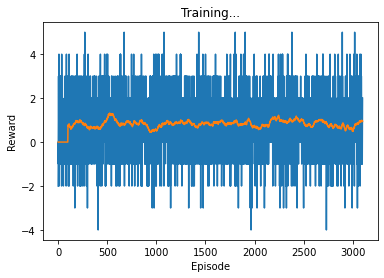

[-2.0, 0.0, 0.0, -1.0, 3.0, 0.0, 1.0, 0.0, 4.0, -1.0, -2.0, 0.0, 3.0, 2.0, 1.0, 1.0, 1.0, 2.0, 3.0, 0.0, -1.0, 2.0, 2.0, 0.0, 1.0, 2.0, 3.0, 2.0, 3.0, 0.0, 1.0, -1.0, -1.0, 1.0, 0.0, -2.0, 4.0, 1.0, -1.0, 2.0, 0.0, 0.0, 3.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, -1.0, 1.0, 0.0, -2.0, 1.0, -1.0, 0.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 3.0, 1.0, -1.0, 0.0, 1.0, 0.0, -1.0, 2.0, 0.0, 0.0, 1.0, -1.0, -2.0, 2.0, 2.0, 4.0, 0.0, 2.0, -1.0, 2.0, 0.0, 2.0, 1.0, 0.0, 2.0, 0.0, 3.0, 1.0, 2.0, 1.0, 1.0]
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  

In [24]:
#import pickle

#memory.save('memory_checkpoint.pth')
plot(ep_rewards, 100, test_rewards)
print(ep_rewards[:100])
moving_avg_rwd = get_moving_average(100, ep_rewards[:100])
print(moving_avg_rwd)

## Test the DQN agent

[(22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8)]
[(90.0, 8), (112.5, 8), (67.5, 8), (45.0, 8), (135.0, 8), (45.0, 8), (90.0, 8)]


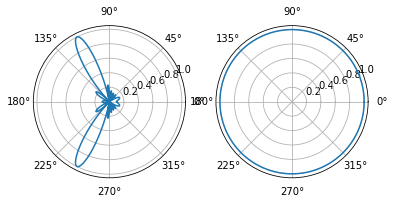

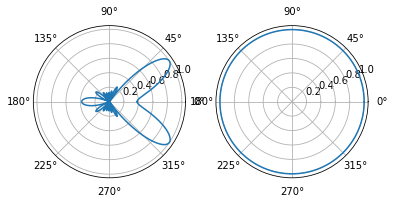

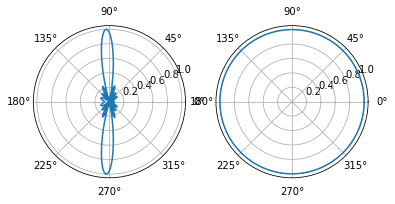

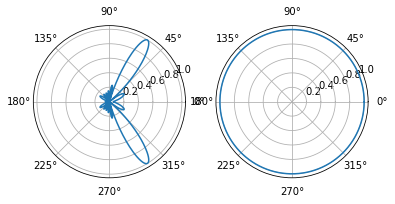

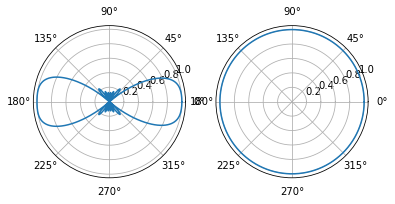

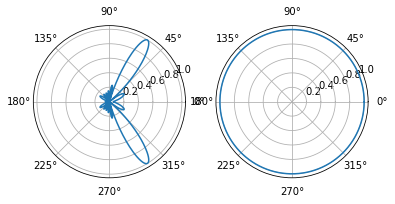

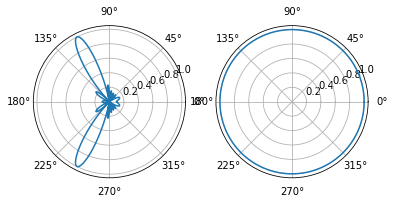

In [25]:
from Source.misc_fun.utils import var_plotbeam

print(tx_dirs)
print(rx_dirs)
for tx_ang, rx_ang in zip(tx_dirs, rx_dirs):
    tx_theta, tx_gr = var_plotbeam(tx_ang, em.env.N_tx)
    rx_theta, rx_gr = var_plotbeam(rx_ang, em.env.N_rx)
    ax1 = plt.subplot(122, projection='polar')
    ax1.plot(tx_theta, tx_gr)

    ax2 = plt.subplot(121, projection='polar')
    ax2.plot(rx_theta, rx_gr)

    plt.show()




## Display all exhaustive rate measurements from env

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

fig = plt.figure()
ax = fig.gca(projection='3d')
poly = PolyCollection(verts[:4], facecolors=['r', 'g', 'b', 'y'], alpha=0.6)
print(len(verts))
print(verts[0:2])
#print(np.array(tx_locs[:4]))
ax.add_collection3d(poly, zs=np.arange(1,5), zdir='y')

ax.set_xlabel('X (beam pairs)')
ax.set_ylabel('Y (tx_locs)')
ax.set_zlabel('Z (data rates)')
ax.set_xlim(0, 10)
ax.set_ylim(1, 5)
ax.set_zlim(10, 30)

plt.show()

In [26]:
print(em.env.ch_model)
print(em.env.sc_xyz)
em.env.BeamSet[5][0]*180/np.pi
np.arctan(1100/200)*180/np.pi

uma-nlos
[[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]


79.69515353123397

In [27]:
12/24, 14/24

(0.5, 0.5833333333333334)

from Source.misc_fun.utils import plotbeam

tx_theta, tx_gr = plotbeam(exh_txbeams[0]*(np.pi/180), em.env.N_tx)
rx_theta, rx_gr = plotbeam(exh_rxbeams[0]*(np.pi/180), em.env.N_rx)
ax1 = plt.subplot(122, projection='polar')
ax1.plot(tx_theta, tx_gr)

ax2 = plt.subplot(121, projection='polar')
ax2.plot(rx_theta, rx_gr)

plt.show()

